In [1]:
import numpy as np
import scipy.io
from scipy.ndimage import gaussian_filter1d
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

np.random.seed(42)

In [2]:
# preallocate the subject classifier results 
sub_accuracy_total_all = np.zeros((21, 776))
sub_accuracy_total_ss1 = np.zeros((21, 776))
sub_accuracy_total_ss2 = np.zeros((21, 776))

sub_accuracy_total_all_perm = np.zeros((21, 776))
sub_accuracy_total_ss1_perm = np.zeros((21, 776))
sub_accuracy_total_ss2_perm = np.zeros((21, 776))

In [5]:
# take all eeg files in .mat (preprocessed)
import glob

filename = []
for idx, file in enumerate(glob.glob('*_theta.mat')):
    #filename = np.append(filename, file)
    mat = scipy.io.loadmat(file)
    print(f"the subject is {file}")

    # get the parameters of eeg data and behavioral data
    nBlocks = mat['class']['nBlocks'][0,0][0,0]
    nBins = mat['class']['nBins'][0,0][0,0]
    nIter= mat['class']['nIter'][0,0][0,0]
    nTime = mat['class']['time'][0,0][0]
    nSamps = len(mat['class']['time'][0,0][0])
    labels = mat['labels']
    blockNum = mat['blockNum']
    nIter = 100
    
    # get the data from the subject
    blockDat_total = mat['data']['blockDat_total'][0][0]
    blockDat_total_SS1 = mat['data']['blockDat_total_SS1'][0][0]
    blockDat_total_SS2 = mat['data']['blockDat_total_SS2'][0][0]

    # get the posterior channels data
    blockDat_total = blockDat_total[:,8:16,:,:]
    blockDat_total_SS1 = blockDat_total_SS1[:,8:16,:,:]
    blockDat_total_SS2 = blockDat_total_SS2[:,8:16,:,:]
    
    # Start the svm model
    # Initialize empty arrays for storing accuracy
    accuracy_total_all = np.zeros((nBlocks, nSamps, int(nIter/10)))
    accuracy_total_ss1 = np.zeros((nBlocks, nSamps, int(nIter/10)))
    accuracy_total_ss2 = np.zeros((nBlocks, nSamps, int(nIter/10)))

    # Instantiate the label encoder
    le = LabelEncoder()

    print(f"subject: {idx+1}")
    start_time = time.time()
    for ite in range(int(nIter/10)):
        for t in range(nSamps):
            de_All = blockDat_total[:,:,t,ite]
            de_SS1 = blockDat_total_SS1[:,:,t,ite]
            de_SS2 = blockDat_total_SS2[:,:,t,ite]
            # for the all total data
            for i in range(nBlocks):

                y_train = le.fit_transform(labels[blockNum[:,1]!=i+1,ite])
                y_test = le.fit_transform(labels[blockNum[:,1]==i+1,ite])
                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_All[blockNum[:,1]==i+1,:]

                # Fit the SVM model
                clf = svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)

                # Predict probabilities for the test set
                y_pred = clf.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_all[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS1 total data
            for i in range(nBlocks):

                y_train = labels[blockNum[:,1]!=i+1,ite]
                y_test = labels[blockNum[:,1]==i+1,ite]
                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS1[blockNum[:,1]==i+1,:]

                # Fit the SVM model
                clf = svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)

                # Predict probabilities for the test set
                y_pred = clf.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss1[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS2 total data
            for i in range(nBlocks):

                y_train = labels[blockNum[:,1]!=i+1,ite]
                y_test = labels[blockNum[:,1]==i+1,ite]
                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS2[blockNum[:,1]==i+1,:]

                # Fit the SVM model
                clf = svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)

                # Predict probabilities for the test set
                y_pred = clf.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss2[i, t, ite] = accuracy_score(y_test, y_pred) 

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"The subject took {elapsed_time:.2f} seconds to execute training.")
    
    # take the subject's classification response to the group array
    sub_accuracy_total_all[idx, :] = np.mean(np.mean(accuracy_total_all,2),0)
    sub_accuracy_total_ss1[idx, :] = np.mean(np.mean(accuracy_total_ss1,2),0)
    sub_accuracy_total_ss2[idx, :] = np.mean(np.mean(accuracy_total_ss2,2),0)
    
    # have the permuation
    # Initialize empty arrays for storing accuracy
    accuracy_total_all_perm = np.zeros((nBlocks, nSamps, nIter))
    accuracy_total_ss1_perm = np.zeros((nBlocks, nSamps, nIter))
    accuracy_total_ss2_perm = np.zeros((nBlocks, nSamps, nIter))

    start_time = time.time()
    for ite in range(nIter):

        for t in range(nSamps):
            de_All = blockDat_total[:,:,t,ite]
            de_SS1 = blockDat_total_SS1[:,:,t,ite]
            de_SS2 = blockDat_total_SS2[:,:,t,ite]

            # for the all total data
            for i in range(nBlocks):

                y_train = np.random.permutation(labels[blockNum[:,1]!=i+1,ite])
                y_test = np.random.permutation(labels[blockNum[:,1]==i+1,ite])
                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_All[blockNum[:,1]==i+1,:]

                # Fit the SVM model
                clf = svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)

                # Predict probabilities for the test set
                y_pred = clf.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_all_perm[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS1 total data
            for i in range(nBlocks):

                y_train = np.random.permutation(labels[blockNum[:,1]!=i+1,ite])
                y_test = np.random.permutation(labels[blockNum[:,1]==i+1,ite])
                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS1[blockNum[:,1]==i+1,:]

                # Fit the SVM model
                clf = svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)

                # Predict probabilities for the test set
                y_pred = clf.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss1_perm[i, t, ite] = accuracy_score(y_test, y_pred)

            # for the SS2 total data
            for i in range(nBlocks):

                y_train = np.random.permutation(labels[blockNum[:,1]!=i+1,ite])
                y_test = np.random.permutation(labels[blockNum[:,1]==i+1,ite])
                X_train = de_All[blockNum[:,1]!=i+1,:]
                X_test = de_SS2[blockNum[:,1]==i+1,:]

                # Fit the SVM model
                clf = svm.SVC(kernel='linear')
                clf.fit(X_train, y_train)

                # Predict probabilities for the test set
                y_pred = clf.predict(X_test)

                # Compute the accuracy of the classifier on the testing data
                accuracy_total_ss2_perm[i, t, ite] = accuracy_score(y_test, y_pred) 

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Took {elapsed_time:.2f} seconds to execute in permutation.")
    
    # take the subject's classification response to the group array
    sub_accuracy_total_all_perm[idx, :] = np.mean(np.mean(accuracy_total_all_perm,2),0)
    sub_accuracy_total_ss1_perm[idx, :] = np.mean(np.mean(accuracy_total_ss1_perm,2),0)
    sub_accuracy_total_ss2_perm[idx, :] = np.mean(np.mean(accuracy_total_ss2_perm,2),0)

the subject is 27_theta.mat
subject: 1
The subject took 44.94 seconds to execute training.
Took 449.57 seconds to execute in permutation.
the subject is 12_theta.mat
subject: 2
The subject took 44.72 seconds to execute training.
Took 531.39 seconds to execute in permutation.
the subject is 19_theta.mat
subject: 3
The subject took 54.50 seconds to execute training.
Took 539.09 seconds to execute in permutation.
the subject is 14_theta.mat
subject: 4
The subject took 59.47 seconds to execute training.
Took 572.51 seconds to execute in permutation.
the subject is 26_theta.mat
subject: 5
The subject took 52.78 seconds to execute training.
Took 572.38 seconds to execute in permutation.
the subject is 13_theta.mat
subject: 6
The subject took 59.87 seconds to execute training.
Took 702.45 seconds to execute in permutation.
the subject is 18_theta.mat
subject: 7
The subject took 54.59 seconds to execute training.
Took 638.03 seconds to execute in permutation.
the subject is 7_theta.mat
subject

In [7]:
# save out the results
np.savez('svm_results_theta', svm_total_all= sub_accuracy_total_all,
                        svm_total_ss1= sub_accuracy_total_ss1,
                        svm_total_ss2= sub_accuracy_total_ss2,
                        svm_total_all_perm= sub_accuracy_total_all_perm,
                        svm_total_ss1_perm= sub_accuracy_total_ss1_perm,
                        svm_total_ss2_perm= sub_accuracy_total_ss2_perm)

new_data = np.load('svm_results_theta.npz')
print(f'{new_data.files}')

['svm_total_all', 'svm_total_ss1', 'svm_total_ss2', 'svm_total_all_perm', 'svm_total_ss1_perm', 'svm_total_ss2_perm']


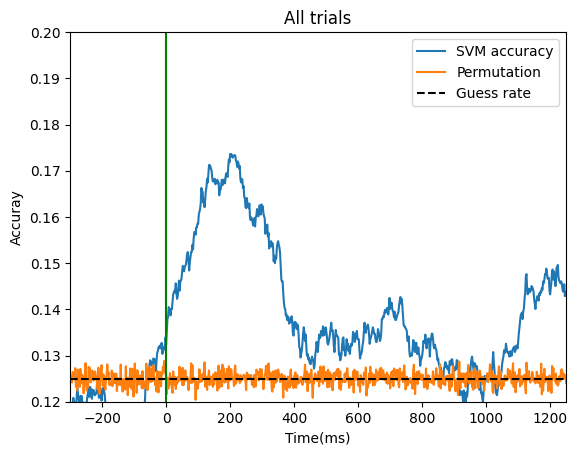

In [8]:
# do student two-sample t-test with fdr correction on ALL Trials
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

p1 = np.mean(sub_accuracy_total_all,0)
p2 = np.mean(sub_accuracy_total_all_perm,0)

# Run a t-test to compare the means of the two datasets
t_statistic, p_value = stats.ttest_ind(sub_accuracy_total_all, sub_accuracy_total_all_perm)

# Apply FDR correction to the p-values
rejected, p_values_corrected = fdrcorrection(p_value)

# Plot the classification accuracy and permutation with significant differences highlighted
fig, ax = plt.subplots()
ax.plot(nTime, p1, label='SVM accuracy')
ax.plot(nTime, p2, label='Permutation')
ax.plot(nTime, [1/nBins]*len(nTime), linestyle='--', color='black',label='Guess rate')
ax.axvline(x=0, color='green')
ax.set_title('All trials')
ax.set_ylabel('Accuray')
ax.set_ylim([0.12, 0.20])
ax.set_xlabel('Time(ms)')
ax.set_xlim([nTime[0], nTime[-1]])
for i, p in enumerate(p_values_corrected):
    if p < 0.05:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='grey')
ax.legend()
plt.savefig('svm_all_result_theta.png')
plt.show()

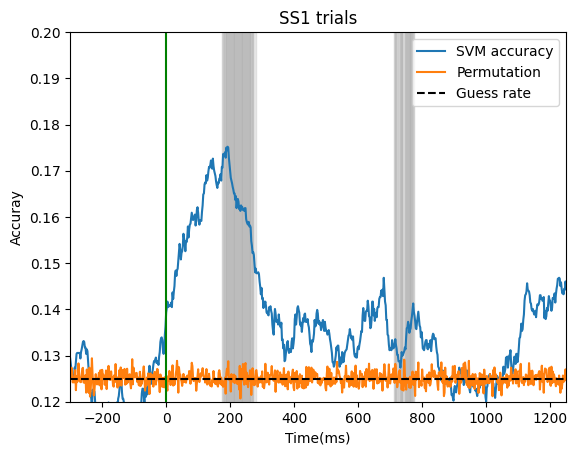

In [9]:
# do student two-sample t-test with fdr correction on SS1 Trials
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

# average across the subjects
p1 = np.mean(sub_accuracy_total_ss1,0)
p2 = np.mean(sub_accuracy_total_ss1_perm,0)

# Run a t-test to compare the means of the two datasets
t_statistic, p_value = stats.ttest_ind(sub_accuracy_total_ss1, sub_accuracy_total_ss2_perm)

# Apply FDR correction to the p-values
rejected, p_values_corrected = fdrcorrection(p_value)


# Plot the classification accuracy and permutation with significant differences highlighted
fig, ax = plt.subplots()
ax.plot(nTime, p1, label='SVM accuracy')
ax.plot(nTime, p2, label='Permutation')
ax.plot(nTime, [1/nBins]*len(nTime), linestyle='--', color='black',label='Guess rate')
ax.axvline(x=0, color='green')
ax.set_title('SS1 trials')
ax.set_ylabel('Accuray')
ax.set_ylim([0.12, 0.20])
ax.set_xlabel('Time(ms)')
ax.set_xlim([nTime[0], nTime[-1]])
for i, p in enumerate(p_values_corrected):
    if p < 0.05:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='grey')
ax.legend()
plt.savefig('svm_ss1_result_theta.png')
plt.show()

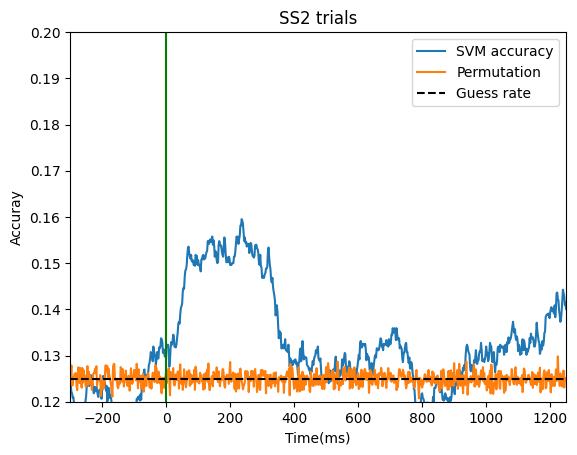

In [10]:
# do student two-sample t-test with fdr correction on SS1 Trials
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

# have the p1 and p2 data across all subjects
p1 = np.mean(sub_accuracy_total_ss2,0)
p2 = np.mean(sub_accuracy_total_ss2_perm,0)

# Run a t-test to compare the means of the two datasets
t_statistic, p_value = stats.ttest_ind(sub_accuracy_total_ss2, sub_accuracy_total_ss2_perm)

# Apply FDR correction to the p-values
rejected, p_values_corrected = fdrcorrection(p_value)

# Plot the classification accuracy and permutation with significant differences highlighted
fig, ax = plt.subplots()
ax.plot(nTime, p1, label='SVM accuracy')
ax.plot(nTime, p2, label='Permutation')
ax.plot(nTime, [1/nBins]*len(nTime), linestyle='--', color='black',label='Guess rate')
ax.axvline(x=0, color='green')
ax.set_title('SS2 trials')
ax.set_ylabel('Accuray')
ax.set_ylim([0.12, 0.20])
ax.set_xlabel('Time(ms)')
ax.set_xlim([nTime[0], nTime[-1]])
for i, p in enumerate(p_values_corrected):
    if p < 0.05:
        ax.axvspan(i-0.5, i+0.5, alpha=0.1, color='grey')
ax.legend()
plt.savefig('svm_ss2_result_theta.png')
plt.show()